# Collaboration and Competition

### Introduction

In this environment, two agents control rackets to bounce a ball over a net.

![IMAGE ALT TEXT](tennis.gif)

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The task is episodic, and in order to solve the environment, your agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
This yields a single score for each episode.
The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

### 1. Start the Environment

Installing necessary packages

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


Loading necessary packages

In [2]:
import torch
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent

from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Obtain information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Behavior of untrained agent

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. Training the agent

##### The algorithm
The algorithm used in this project was DDPG (Deep Deterministic Policy Gradient). This algortithm learns a Q-function and a policy at the same time. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.

DDPG is adapted to continuous environments thanks to how we compute the maximum over actions in $max_a Q^*(s,a)$. Since we cannot exhaustively evaluate the space each time we need to compute $max_a Q(s,a)$ we can approximate it with $max_a Q(s,a) \approx Q(s,\mu(s))$.

Also, is important to note the use of a replay buffer, which is a set of past experiences. The DDPG algorithm sample past experiences from this set in order to learn, the replay buffer should be large enough to contain a significant number of experiences to learn, however, if the buffer is too large the learning process might be  too slow.

##### Hyperparameters 
We used the DDPG algorithm to solve this problem, the agent was capable of solving the environment after 1,300 episodes.

Is important to know the hyperparameters used in this algorithm:
- Buffer size (100,000) is the capacity of the replay buffer
- Batch size (256) is the size of the batch sampled and learned from each iteration
- Gamma (0.99) is the discount factor for the rewards
- Tau (0.001) is the rate of soft updates of target parameters
- Learning rate of actor (0.0001)
- Learning rate of critic (0.001)

Now, we present the architechture of the actor and the critic

##### Actor model
In the case of the actor, we used 2 fully connected hidden layers with 128 and 64 units each and ReLU as activation function except for the output layer where we used a tanh activation function.

We had 33 inputs (state size) as input to the network and 4 (action size) as output neurons.

##### Critic model
For the critic, we used 2 fully connected hidden layers with 130 (128 + size of each action) and 64 units each and ReLU as activation function.

We had 33 inputs (state size) as input to the network and 1 neuron (for the Q value estiamtion) as output.

##### Cold start and stability

After several trials, we found that the beginning of the learning process is quite unstable, we think the main reason for this is the lack of enough experiences to learn (cold start problem), since with enough episodes the algorithm is able to solve the environment, in the trails we did the algorithm took between 1,000 and 4,000 episodes to solve the environment. We present in this notebook one of the fastest trials.

In [6]:
def maddpg(n_episodes = 4000, max_t = 1000, print_every = 100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]   # Reset the environment  
        states = env_info.vector_observations               # Get the current state
        scores_agents = np.zeros(num_agents)
        score = 0
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states)                               # Select an action
            env_info = env.step(actions)[brain_name]                  # Send the action to tne environment
            next_states = env_info.vector_observations                # Get the next state
            rewards = env_info.rewards                                # Get the reward    
            dones = env_info.local_done                               # See if episode has finished
            agent.step(states, actions, rewards, next_states, dones)  # Step and learning process
            scores_agents += rewards
            states = next_states
            if np.any(dones):
                break 
        score = np.max(scores_agents)
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.5:
            print('\rThe average score over the last 100 episodes was: {:.4f}'.format(np.mean(scores_deque)))
            break
            
    return scores

Episode 100	Average Score: 0.0030
Episode 200	Average Score: 0.0000
Episode 300	Average Score: 0.0088
Episode 400	Average Score: 0.0029
Episode 500	Average Score: 0.0134
Episode 600	Average Score: 0.0105
Episode 700	Average Score: 0.0360
Episode 800	Average Score: 0.0650
Episode 900	Average Score: 0.0841
Episode 1000	Average Score: 0.1004
Episode 1100	Average Score: 0.1167
Episode 1200	Average Score: 0.3123
The average score over the last 100 episodes was: 0.5082


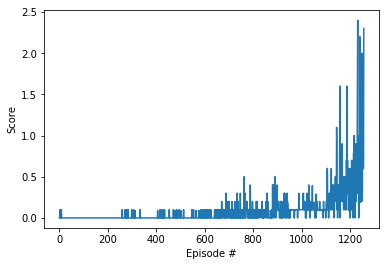

In [7]:
agent = Agent(state_size = state_size, action_size = action_size, random_seed = 17)
scores = maddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

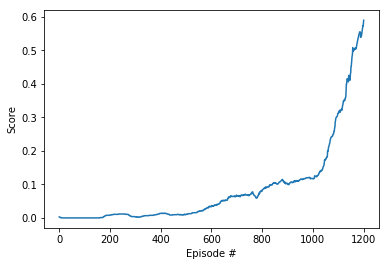

In [10]:
ma_scores = []
for i in range(1200):
    ma_scores.append(np.mean(scores[i:i+100]))
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(ma_scores)+1), ma_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Behavior of trained agent

In [11]:
for i in range(5):                                         # Play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # Reset the environment    
    states = env_info.vector_observations                  # Get the current state (for each agent)
    scores = np.zeros(num_agents)                          # Initialize the score (for each agent)
    while True:
        actions = actions = agent.act(states)              # Select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # Send all actions to tne environment
        next_states = env_info.vector_observations         # Get next state (for each agent)
        rewards = env_info.rewards                         # Get reward (for each agent)
        dones = env_info.local_done                        # See if episode finished
        scores += env_info.rewards                         # Update the score (for each agent)
        states = next_states                               # Roll over states to next time step
        if np.any(dones):                                  # Exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: 0.19500000309199095
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.29500000458210707
Total score (averaged over agents) this episode: 2.3450000351294875


In [12]:
env.close()

### 6. Ideas for Future work

1. Creating 2 actors and 2 critics mights improve the speed of performance.
2. Monte Carlo Tree Search can improve the speed and stability of learning.